In [1]:
import Pkg
Pkg.activate(".")
Pkg.instantiate();

  Activating project at `~/syndr/Wouter/Onderzoek/Demonstraties/tue/RxAgents/Thermostat`


In [2]:
using RxInfer
using Rocket
using GraphPPL
using Plots
using ReactiveMP
import ReactiveMP: getinterface, messageout

In [3]:
# Parameters
zₜ = MvNormalMeanCovariance(zeros(2),diageye(2))
T = 2
A = B = C = Q = diageye(2)
P = diageye(2) * tiny

θᵤ = MvNormalMeanCovariance(zeros(2),diageye(2)*100)
goals = [ones(2) * 1 for t in 1:T]

2-element Vector{Vector{Float64}}:
 [1.0, 1.0]
 [1.0, 1.0]

There are several ways of constructing Bayesian agents that are consistent with the FEP. In this notebook we will focus on the simplest to implement in ReactiveMP and save more esoteric versions for later. 

The agent described here is an instance of model predictive control implemented by message passing on a graph. It infers the optimal sequence of actions to obtain some goal, defined as a prior on desired future observations.

Concretely the agent is a state space model that performs online filtering. Additionally the model is extended a number of timesteps T into the future. Given goal priors on future observations, we can then perform a smoothing pass to obtain the optimal sequence of controls. Let's construct the generative model for the agent.

In [4]:
@model function controller_reactive(T, A, B, Q, P, C, θᵤ)

    cA = constvar(A) # Transition matrix
    cQ = constvar(Q) # Transition noise
    cB = constvar(B) # Emission matrix
    cC = constvar(C) # Control matrix
    
    # Vector of reference to factor nodes of latent states. Useful for later
    znodes = Vector{}(undef, T)
    
    z = randomvar(T) # Hidden states
    u = randomvar(T) # Control states

    x = datavar(Vector{Float64}, T) # Goal priors
    cP = constvar(P) # Goal prior variance

    # 
    z_current_mean = datavar(Vector{Float64})
    z_current_cov  = datavar(Matrix{Float64})
    
    # Prior state
    z_prior ~ MvNormalMeanCovariance(z_current_mean, z_current_cov)
    z_prev = z_prior
    
    # Current observation for filtering
    x_0 = datavar(Vector{Float64})
    x_0 ~ MvNormalMeanCovariance(cB * z_prior, cP)

    # Extend the model T steps into the future
    for t in 1:T
        u[t] ~ MvNormalMeanCovariance(mean(θᵤ), cov(θᵤ))
        znodes[t], z[t] ~ MvNormalMeanCovariance(cA * z_prev + cC * u[t], cQ)
        x[t] ~ MvNormalMeanCovariance(cB * z[t], cP)
        z_prev = z[t]
    end

    return x, x_0, z, znodes, u, z_current_mean, z_current_cov
end

The agent does not live in a vacuum though. We must construct an environment for it to interact with, as well as some interfaces between them. Let's define some structs to help with this. We will dispatch on these once we set up the action/perception loop.

In [5]:
struct NewControlPosteriorFromModel
    posterior
end

struct NewObservationFromEnvironment
    observation
end

Now we are ready to define an environment and a constructor for it. We make the environment an actor so our agent can subscribe to it and receive observations. The Environment struct holds the true state of the agent and an "event" variable that the agent will subscribe to.

In [6]:
struct Environment <: Actor{Any}
    
    real_position :: Vector{Float64}
    
    events # :: Subject{Any} <- event emitter
end

function Environment()
    real_position = zeros(2)
    
    # BehaviorSubject allows us to set the initial state
    events = BehaviorSubject(NewObservationFromEnvironment(real_position))
    
    return Environment(real_position, events)
end

Environment

To have the environment update upon receiving an action from the agent, we define a method for the `on_next` function that dispatches on `Environment` and `NewControlPosteriorFromModel`.

In [7]:
function Rocket.on_next!(environment::Environment, event::NewControlPosteriorFromModel)
    # println("Event to our env: ", mean(first(event.posterior)))
    # Update position with the mean of the first planned action.
    next_real_position = environment.real_position .+ mean(first(event.posterior))
    
    # Set the position variable in the environment 
    copyto!(environment.real_position, next_real_position)
    
    # Update environment and emit a new observation
    next!(environment.events, NewObservationFromEnvironment(next_real_position))
end

Now we can define a constructor for our agent in a similar manner. Besides needing a generative model, we require the agent to be able to run inference, emit actions, listen to the environment and keep track of some internal variables

In [8]:
struct PlanningModel <: Actor{Any}
    model
    model_variables
    prediction_subscription
    control_subscription
    events :: Subject{Any}
end

function PlanningModel()
    model, (x, x_0, z, znodes, u, zcm, zcc) = create_model(controller_reactive(T, A, B, P, Q, C, θᵤ));
    
    # Set initial state priors
    update!(zcm, zeros(2))
    update!(zcc, diageye(2))
    
    # Subject allows the agent to emit actions that can be picked up by the environment
    events = Subject(Any)
    
    # Update the prior by performing a single filtering step. note that we get the _message_
    # instead of the _marginal_ here to prevent erroneous information from the future
    prediction_subscription = subscribe!(
        messageout(getinterface(znodes[1], :out)), (prediction_z_1) -> begin
        m, c = mean_cov(prediction_z_1)
        update!(zcm, m)
        update!(zcc, c)
    end)
    
    # Emit an action whenever the control marginals are updated
    control_subscription = subscribe!(getmarginals(u), (posterior_u) -> next!(events, NewControlPosteriorFromModel(posterior_u)))
    
    # Construct model
    return PlanningModel(model, (x, x_0, z, znodes, u, zcm, zcc), prediction_subscription, control_subscription, events)
end

PlanningModel

One thing we need to keep in mind is that, in order to maintain correct state estimates, the agent should not update it's priors based on backwards messages from the future. This is why `prediction_subscription` needs to get the outgoing message from the first transition node instead of the marginal

Once again we define a new method for `on_next` that allows the agent to update itself upon receiving new observations from the environment

In [9]:
function Rocket.on_next!(model::PlanningModel, event::NewObservationFromEnvironment)
    # println("Event to our model: ", event)
    (x, x_0, z, znodes, u, zcm, zcc) = model.model_variables
    update!(x_0, event.observation)
end

# function Rocket.on_next!(model::PlanningModel, event::FatalErrorEvent)
#     unsubscribe!(model.control_subscription)
# end

Now we are ready to instantiate our agent and its environment!

In [10]:
environment = Environment();
model = PlanningModel();

Let's have the agent and environment listen to each other.

In [11]:
env_to_model_subscription = subscribe!(environment.events,       model)
model_to_env_subscription = subscribe!(model.events,       environment)

LoadError: MethodError: no method matching iterate(::VariationalMessage{Tuple{ReactiveMP.MessageObservable{Message}}, Tuple{SingleObservable{Marginal{PointMass{Matrix{Float64}}, Nothing}, AsapScheduler}}, ReactiveMP.MessageMapping{MvNormalMeanCovariance, Val{:out}, Marginalisation, Val{(:μ,)}, Val{(:Σ,)}, Nothing, Nothing, Nothing}})
[0mClosest candidates are:
[0m  iterate([91m::Union{LinRange, StepRangeLen}[39m) at range.jl:872
[0m  iterate([91m::Union{LinRange, StepRangeLen}[39m, [91m::Integer[39m) at range.jl:872
[0m  iterate([91m::T[39m) where T<:Union{Base.KeySet{<:Any, <:Dict}, Base.ValueIterator{<:Dict}} at dict.jl:712
[0m  ...

We trigger each loop on a timer. In principle this is not necessary, since the loop continually updates once all datavariables are filled in. So any mechanism for setting variables will work, for example having the agent listen to an external sensor

In [12]:
t = timer(0, 100); # Update once every second

In [13]:
# Set goal priors every time the timer ticks. This fills in the remaining datavars and triggers a round
# of message passing
timer_subscription = subscribe!(t, (_) -> begin 
    let 
        (x, x_0, z, znodes, u, zcm, zcc) = model.model_variables
        update!(x, goals)
    end
end)
;

We can also update the agents goals on a slower time scale. To do this we can set a different timer, add a subscription and listen to it. In principle we could run a separate agent here and have it emit goal states.

In [14]:
goals_timer = timer(0, 500)

goals_subscription = subscribe!(goals_timer, (index) -> begin
    x = sin(index / π)
    y = cos(index / π)
    new_goal = [ x, y ]
    # println("We have a new goal: ", new_goal,"\n")
    for i in 1:T
        copyto!(goals[i], new_goal)
    end
end)

TimerSubscription()

In [15]:
# Initial plotting for compilation
plot(1:10, 1:10);

In [16]:
struct PlotActor <: Actor{Any} 
    previous
    
    PlotActor() = new([])
end

function Rocket.on_next!(actor::PlotActor, event::NewObservationFromEnvironment)
    push!(actor.previous, event)
    
    pick = 50
    
    range = max(1, length(actor.previous) - pick):length(actor.previous)
    
    p = plot(ylims = (-2, 2))
    p = plot!(p, range, map(e -> e.observation[1], actor.previous[range]), label = "Real state")
    p = hline!(p, [ goals[1][1] ], label = "Goal state")
    
    IJulia.clear_output(true);
    display(p)
end

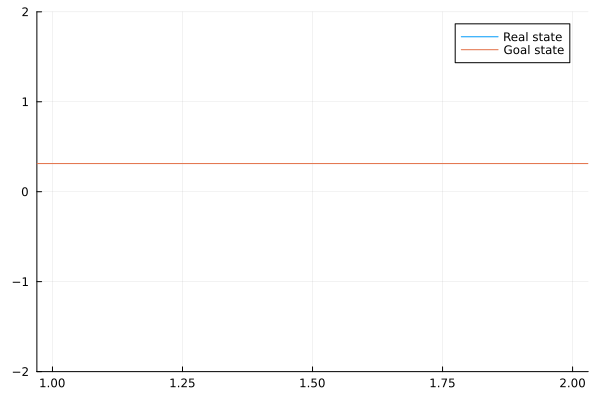

SubjectSubscription()

In [17]:
plot_subscription = subscribe!(environment.events, PlotActor())

As is, the action/perception loop will run indefinitely. To stop it, we can cancel our subscriptions so we don't fill the goal priors. While they remain unfulfilled, we wont trigger a new cycle of message passing

In [18]:
unsubscribe!(timer_subscription)
unsubscribe!(goals_subscription)
unsubscribe!(plot_subscription)
IJulia.clear_output(false);